In [2]:
import numpy as np
import itertools
from collections import Counter
import pandas as pd
import networkx as nx
import io
import statistics as stats


%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.axes as axes

# Defining Our Algorithms

In [3]:
# input: p, q, G: adjacency matrix of the current graph
# output: a new edge to be added to the graph
def TCER_single_edge(G, q=.1, p=.01):
  # figure out what are type A and B edges
  n = G.shape[0]
  #
  G2 = G.dot(G)
  mask_A = (G==0)&(G2!=0)
  mask_B = (G==0)&(G2==0)
  A_edges, B_edges = [], []
  for i,j in itertools.combinations(range(n), 2):
    if mask_A[i,j]:
      A_edges.append((i,j))
    if mask_B[i,j]:
      B_edges.append((i,j))
  # how to choose a single edge given A_edges and B_edges and p, q:
  m1, m2 = len(A_edges), len(B_edges)
  # the probability to add a new edge of type A
  p1 = (m1*q)/(m1*q+m2*p)
  r = np.random.random(1)
  if r<p1:
    # output a type A edge
    i1 = np.random.choice(m1)
    return A_edges[i1]
  else:
    # output type B edge
    i2 = np.random.choice(m2)
    return B_edges[i2]

def TCER(G, q=.1,p=.01, t=1):
  Gt = G.copy()
  edge_list = []
  for j in range(t):
    e = TCER_single_edge(Gt, q, p)
    i1, i2 = e
    Gt[i1,i2] = 1
    Gt[i2,i1] = 1
    edge_list.append(e)
  return Gt, edge_list

In [4]:
# choose some G, p,q and print the A, B type edges
n = 25
G0 = np.zeros((n,n))

Gt, edges = TCER(G0,q=0.5, p=0.1, t=100)
G = nx.from_numpy_array(Gt)



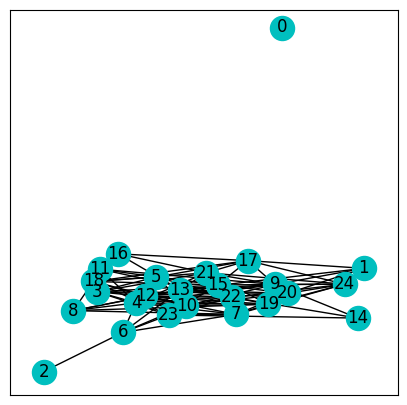

In [5]:
plt.figure(figsize=(5,5))
plt.xticks([])
plt.yticks([])
nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=True,
                  node_color='c')#, cmap="Set2")



In [6]:
nodelist = list(G.nodes)

node_loc = nx.kamada_kawai_layout(G)
A = nx.to_numpy_array(G, nodelist = nodelist)

In [7]:
from sklearn.cluster import spectral_clustering as SCL
clusters = SCL(A, n_clusters=2, random_state = 1234, assign_labels="discretize")
print(clusters)


[1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


In [8]:
eig_measure = nx.eigenvector_centrality(G)
# repeat latr for betweenness measure
sizes = np.array([eig_measure[x] for x in nodelist])
node_cols = np.where(clusters==1, 'b', 'r')
# node_labels = {x:x.partition(' ')[0] for x in nodelist}
node_loc = nx.kamada_kawai_layout(G)

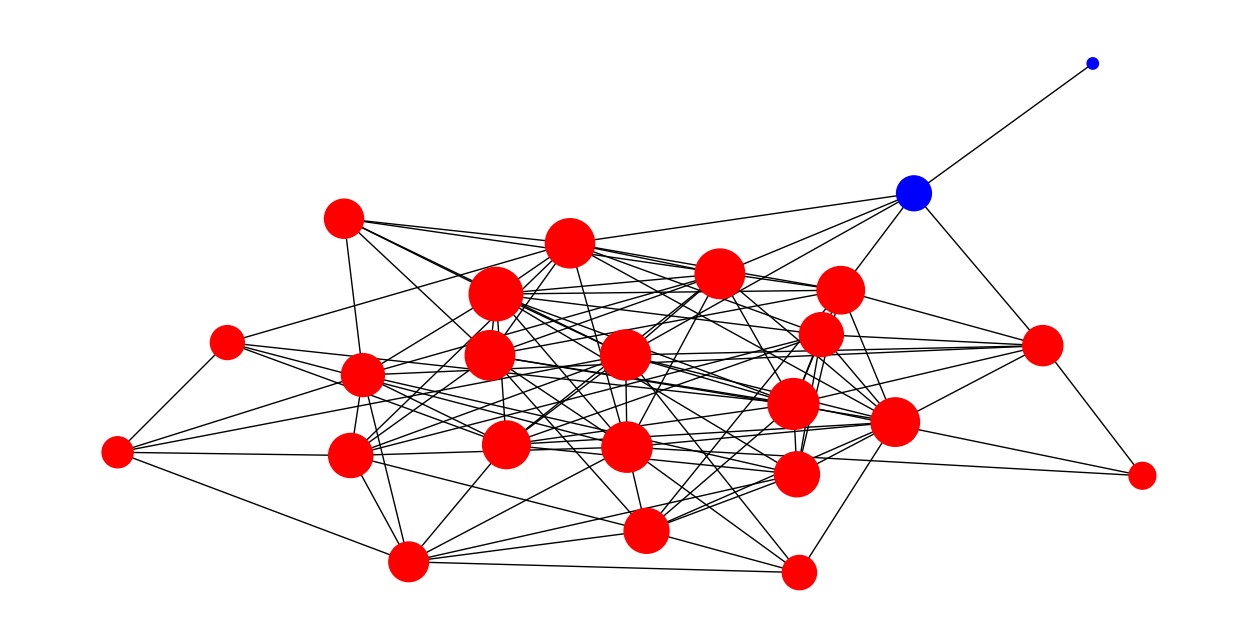

In [9]:
fig = plt.figure(figsize=(16,8))
plt.axis('off')
nx.draw(G, nodelist= nodelist, pos=node_loc, node_color = node_cols, \
node_size = sizes*5e3)

# nx.draw_networkx_labels(G,labels=node_labels, pos=node_loc, font_size=14, \
# font_color='k', font_weight='bold', horizontalalignment='left', verticalalignment='top')

In [ ]:
# next: can we recover the values of p and q from the sequece of the edges added to the graph over time
# input: initial graph: G_0 = empty graph, sequence of the edges added over time: E_t = [e_1,e_2, ..., e_t] => estimate parameters p, q

In [10]:
def likelihood_single_edge(G, e, q=.1, p=.01):
  # figure out what are type A and B edges
  n = G.shape[0]
  #
  G2 = G.dot(G)
  mask_A = (G==0)&(G2!=0)
  mask_B = (G==0)&(G2==0)
  A_edges, B_edges = [], []
  for i,j in itertools.combinations(range(n), 2):
    if mask_A[i,j]:
      A_edges.append((i,j))
    if mask_B[i,j]:
      B_edges.append((i,j))
  # how to choose a single edge given A_edges and B_edges and p, q:
  ma, mb = len(A_edges), len(B_edges)
  # the probability to add a new edge of type A
  pa = q/(ma*q+mb*p)
  pb = p/(ma*q+mb*p)
  if e in A_edges:
    res = pa
  else:
    res = pb
  return res


In [11]:
def edge_likelihoods(G0, edge_list, q=.1,p=.01):
  t = len(edge_list)
  prob_list = []
  Gt = G0.copy()
  for e in edge_list:
    res = likelihood_single_edge(Gt, e, q, p)
    prob_list.append(res)
    i, j = e
    Gt[i,j] = 1
    Gt[j,i] = 1
  return prob_list


In [12]:
G0 = np.zeros_like(Gt)
prob_list = edge_likelihoods(G0, edges, q =.15, p = .02)
pq_likelihood = sum([np.log(p) for p in prob_list])
print(pq_likelihood)

print(edges)

-541.6149964595315
[(9, 12), (4, 7), (15, 23), (16, 21), (1, 17), (18, 23), (8, 19), (6, 13), (4, 12), (12, 13), (18, 21), (19, 20), (3, 21), (11, 16), (9, 10), (22, 23), (6, 7), (6, 10), (3, 23), (5, 17), (15, 22), (7, 19), (9, 13), (7, 24), (15, 17), (5, 15), (4, 10), (7, 12), (10, 20), (1, 24), (5, 10), (4, 19), (5, 20), (19, 21), (4, 6), (7, 22), (7, 20), (3, 22), (3, 15), (19, 22), (11, 22), (13, 23), (3, 5), (7, 8), (8, 12), (13, 20), (4, 21), (14, 23), (9, 24), (10, 12), (1, 9), (3, 12), (4, 9), (7, 15), (6, 23), (9, 14), (5, 22), (8, 13), (7, 23), (10, 13), (5, 12), (5, 13), (9, 11), (1, 13), (16, 18), (9, 21), (16, 17), (12, 22), (12, 15), (5, 11), (10, 19), (2, 6), (10, 22), (17, 21), (12, 18), (3, 20), (15, 24), (4, 8), (9, 19), (9, 20), (5, 18), (13, 21), (10, 18), (13, 22), (3, 4), (1, 20), (13, 16), (4, 20), (9, 17), (17, 18), (17, 24), (19, 24), (8, 18), (14, 22), (20, 24), (12, 19), (15, 18), (22, 24), (4, 11), (21, 24)]


In [ ]:
# we can use scipy optimize method to find parameters
# plot the likelihoods over the entire range of parameters

In [13]:
# range of q/p
q2p_range = np.logspace(-1,2,100)
q2p_range = np.sort(np.append(q2p_range,1))
q2p_range = q2p_range[q2p_range<20]
likelihoods_list = []
for q2p in q2p_range:
  G0 = np.zeros_like(Gt)
  pcur = 1e-2
  qcur = pcur*q2p
  prob_list = edge_likelihoods(G0, edges, q = qcur, p = pcur)
  pq_likelihood = sum([np.log(p) for p in prob_list]) #would it help to divide pq_likelihood by len(prob_list) to find the average probability of an edge?
  likelihoods_list.append(pq_likelihood)


In [ ]:

ER_index = (q2p_range==1).argmax()
print(ER_index)

likelihood_arr = np.array(likelihoods_list)

q2p_best = q2p_range[likelihood_arr.argmax()]
print("argmax is" , q2p_best) #maximum likelihood ratio of q to p (i.e. the effect of triadic closure)
# what were original params: q=0.5, p=0.1 => q/p = 5

ml = max(likelihoods_list)
# the values that lead to a likelihood at most 10% off ml
ml_threshold = ml + np.log(.80)

print("max is" , ml) #Log of probability of observing edges at best choice of q/p (ratio is 3.76)

ER_likelihood = likelihoods_list[ER_index]
print("ER likelihood is" , ER_likelihood) #this is the log of the probability of observed edges if ER(p=q)


print("Difference between log probabilities is" , max(likelihood_arr)- likelihood_arr[ER_index]) #still in log form

log_diff = ml - ER_likelihood

likelihood_ratio = np.exp(log_diff)
print("ratio is" , likelihood_ratio) #This is the ratio of the probabilities of observing edges for best q/p & q=p


print(q2p_range[likelihood_arr>ml_threshold])

33
argmax is 4.977023564332112
max is -533.0337866347505
ER likelihood is -551.6738627526624
Difference between log probabilities is 18.640076117911917
ratio is 124532354.7867559
[4.32876128 4.64158883 4.97702356 5.33669923 5.72236766]


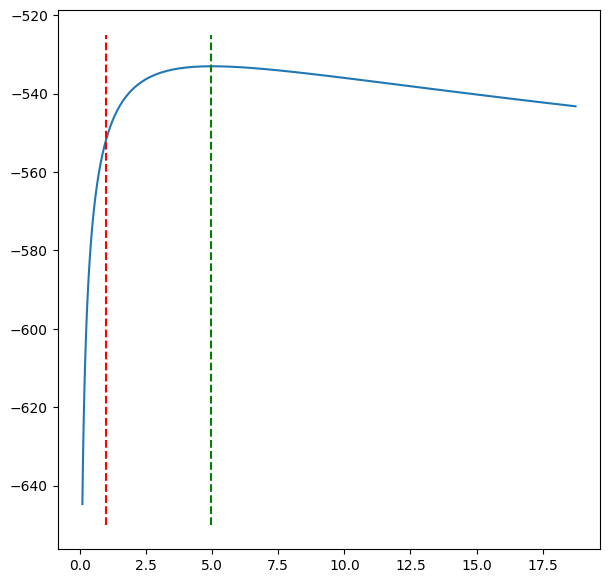

In [ ]:

plt.figure(figsize=(7,7))

plt.plot(q2p_range, likelihoods_list)
plt.vlines(1,-650,-525, 'r', ls='dashed')
plt.vlines(q2p_best,-650,-525, 'g', ls='dashed')


# Network Statistics Calculator

In [ ]:
def net_stats(G):
    n = len(nx.nodes(G))
    e = len(nx.edges(G))
    degrees = dict(G.degree())
    avg_d = sum(degrees.values()) / len(degrees)
    close_cents = nx.closeness_centrality(G)
    avg_close = sum(close_cents.values()) / len(close_cents)
    avg_between = sum(nx.betweenness_centrality.values()) / len(nx.betweenness_centrality)
    cc = nx.average_clustering(G)
    avg_eigen = sum(degrees.values()) / len(degrees)
    connected = nx.is_connected(G)
    if connected == True:
      diam = nx.diameter(G)
    else:
      diam = np.inf


#     print("Number of nodes: " , n , '\n')
#     print("Number of edges: " , e , '\n')
#     print("Average Degree: ", avg_d , '\n')
#     print("Clustering Coefficient: ", cc , "\n")
#     print("Diameter is:" , diam , '\n')
#     print("Network is connected (T/F):" , connected , '\n')

    return n, e, degrees, avg_d, cc, avg_close, avg_between, avg_eigen, diam, connected

In [ ]:



def temp_net_stats(G_list):

    n_list = []
    e_list = []
    avg_d_list = []
    cc_list = []
    diam_list = []
    connected_list = []

    for Gt in G_list:
        n, e, degrees, avg_d, cc, diam, connected = net_stats(Gt)
        n_list.append(n)
        e_list.append(e)
        avg_d_list.append(avg_d)
        cc_list.append(cc)
        diam_list.append(diam)
        connected_list.append(connected)

    if len(connected_list) != len(G_list):
        print("Error: connected_list not same len as G_list")
        print(connected_list)

    #nodes
    max_n = max(n_list)
    min_n = min(n_list)
    avg_n = sum(n_list)/len(n_list)

    #edges
    max_e = max(e_list)
    min_e = min(e_list)
    avg_e = sum(e_list)/len(e_list)

    #average degrees
    max_d = max(avg_d_list)
    min_d = min(avg_d_list)
    avg_d = sum(avg_d_list)/len(avg_d_list)

    #clustering coeffs
    max_cc = max(cc_list)
    min_cc = min(cc_list)
    avg_cc = sum(cc_list)/len(cc_list)

    #added edges
    e_new = max_e - min_e

    #diameter
    max_diam = max(diam_list)
    min_diam = min(diam_list)
    avg_diam = sum(diam_list)/len(diam_list)

    #connected graphs
    connected_counts = Counter(connected_list)
    true_percent = connected_counts[True] / len(connected_list) * 100
    false_percent = connected_counts[False] / len(connected_list) * 100

    print("There are" , len(G_list) , "timestamps")

    if nx.is_directed(G_list[0]) == True:
        print("This graph is directed")
    else:
        print("This graph is not directed")

    if nx.is_weighted(G_list[0]) == True:
        print("This graph is weighted")
    else:
        print("This graph is not weighted")

    has_self_loops = False
    for node in G_list[0].nodes():
        if G_list[0].has_edge(node, node):
            has_self_loops = True
            print("Self loop at" , node)
            break

    if has_self_loops == True:
        print("The graph has self-loops.", '\n')
    else:
        print("The graph does not have self-loops.", '\n')

    print("The max nodes are" , max_n)
    print("The min nodes are" , min_n)
    print("The avg nodes are" , avg_n , '\n')
    print("The max edges are" , max_e)
    print("The min edges are" , min_e)
    print("The avg edges are" , avg_e , '\n')
    print(e_new , "edges were added" , '\n')
    print("The max degree is" , max_d)
    print("The min degree is" , min_d)
    print("The avg degree is" , avg_d , '\n')
    print("The max clustering coeff is" , max_cc)
    print("The min clustering coeff is" , min_cc)
    print("The avg clustering coeff is" , avg_cc , '\n')
    print("The max diameter is" , max_diam)
    print("The min diameter is" , min_diam)
    print("The avg diameter is" , avg_diam , '\n')
    print(f"Connected timestamps: {true_percent:.2f}%" , connected_counts[True])
    print(f"Disconnected timestamps: {false_percent:.2f}%" , connected_counts[False] , '\n')


# Real Data (Monks)

In [ ]:
from google.colab import files
uploaded = files.upload()

TypeError: ignored

In [ ]:
# split the lines in the 'sampson.dat.txt' file
f_lines = str(uploaded['sampson.dat.txt']).split('\\r\\n')
# print a few elements to see how they look like:
print(f_lines[:3])

In [ ]:
# find the index at which the data starts:
ind_s = f_lines.index('DATA:')+1
print(ind_s, len(f_lines), len(f_lines)-ind_s-1)
# print the line at ind_s to see the structure of each data line:
print(f_lines[ind_s])

53 234 180
 0 0 2 0 3 0 0 0 0 0 0 0 0 1 0 0 0 0


In [ ]:
# store the 10 adjacency matrix each with 18 rows:
A_list = []
for cnt in range(10):
    A = np.array([f_lines[ind].split() for ind in range(ind_s+18*cnt,ind_s+18*(cnt+1))]).astype(np.int32)
    A_list.append(A.copy())
#
print(A_list[0])

[[0 0 2 0 3 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [3 0 0 0 0 0 2 0 0 0 0 0 0 1 0 0 0 0]
 [2 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 3 1 0 0 0 2 0 0 0 0 0 0 0 0]
 [0 0 0 3 0 0 0 0 0 0 2 0 1 0 0 0 0 0]
 [1 0 0 3 0 0 0 0 2 0 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 1 0 0 0 0 0 0 0 3 0 0]
 [3 2 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 2 0 0 3 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 3 0 0 0 1 0 0 0 0 0 2 0 0 0 0]
 [0 0 0 0 3 0 0 1 0 0 0 0 0 2 0 0 0 0]
 [3 2 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 2 0 1 0 0 0 0 0 0 0 0 0 0 3]
 [3 0 0 0 0 0 0 0 0 0 1 2 0 0 2 0 0 0]
 [3 2 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [1 2 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0 0 0 2 0 0 0 0 1]
 [2 3 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]]


In [ ]:
#Import Sampson's Monks

edges = []

for At in A_list:
  Gt = nx.from_numpy_array(At) # verify that this works
  for e in Gt.edges:
    edges.append(e)

edge_set = set(edges)
edge_list_nd = list(edge_set)


G = nx.from_edgelist(edge_list_nd)


nodes_list = nx.nodes(G)
n = len(nodes_list)
print(n)


e = nx.edges(G)
number_edges = len(e)
print(number_edges)


18
134


In [ ]:
#Network Statistics HELPPPPPP

G_list = []

G_list = [nx.from_numpy_array(At) for At in A_list]


temp_net_stats(G_list)

There are 10 timestamps
This graph is not directed
This graph is weighted
The graph does not have self-loops. 

The max nodes are 18
The min nodes are 18
The avg nodes are 18.0 

The max edges are 49
The min edges are 32
The avg edges are 40.7 

17 edges were added 

The max degree is 5.444444444444445
The min degree is 3.5555555555555554
The avg degree is 4.522222222222222 

The max clustering coeff is 0.5043209876543209
The min clustering coeff is 0.19007936507936504
The avg clustering coeff is 0.3558064774731441 

The max diameter is inf
The min diameter is 4
The avg diameter is inf 

Connected timestamps: 70.00% 7
Disconnected timestamps: 30.00% 3 



In [ ]:
G0 = np.zeros((n,n))

Gt, edges = TCER(G0,q=0.5, p=0.1, t=100) # DO I NEED THESE WHEN TESTING DATA????

In [ ]:
G = nx.from_numpy_array(Gt)


Text(0.5, 1.0, 'Monks Network')

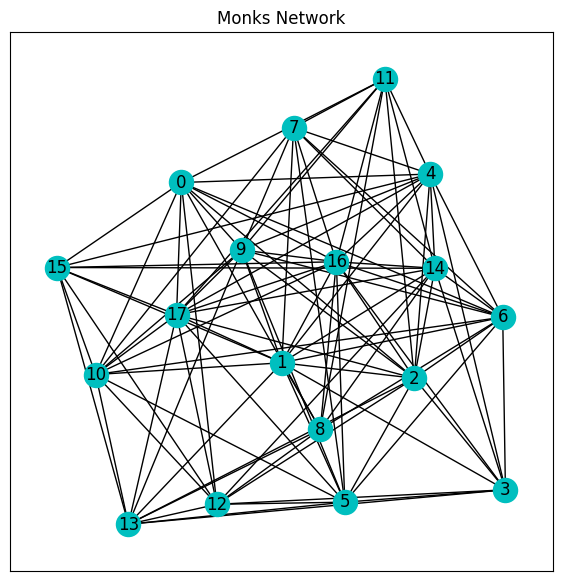

In [ ]:
fig, ax = plt.subplots(figsize=(7,7))
plt.xticks([])
plt.yticks([])
nx.draw_networkx(G, pos=nx.spring_layout(G, seed=4), with_labels=True,
                  node_color='c')                      #names can be accessed with nodes_list

ax.set_title('Monks Network')

In [ ]:

G0 = np.zeros_like(Gt)
prob_list = edge_likelihoods(G0, edges, q =.15, p = .02)
pq_likelihood = sum([np.log(p) for p in prob_list])
print(pq_likelihood)



-452.9855178241721


In [ ]:
q2p_range = np.logspace(-1,2,100)
q2p_range = np.sort(np.append(q2p_range,1))
q2p_range = q2p_range[q2p_range<20]
likelihoods_list = []
for q2p in q2p_range:
  G0 = np.zeros_like(Gt)
  pcur = 1e-2
  qcur = pcur*q2p
  prob_list = edge_likelihoods(G0, edges, q = qcur, p = pcur)
  pq_likelihood = sum([np.log(p) for p in prob_list])
  likelihoods_list.append(pq_likelihood)


In [ ]:
ER_index = (q2p_range==1).argmax()
print(ER_index)

likelihood_arr = np.array(likelihoods_list)

q2p_best = q2p_range[likelihood_arr.argmax()]
print("argmax is" , q2p_best) #maximum likelihood ratio of q to p (i.e. the effect of triadic closure)
# what were original params: q=0.5, p=0.1 => q/p = 5

ml = max(likelihoods_list)
# the values that lead to a likelihood at most 10% off ml
ml_threshold = ml + np.log(.80)

print("max is" , ml) #Log of probability of observing edges at best choice of q/p (ratio is 3.76)

ER_likelihood = likelihoods_list[ER_index]
print("ER likelihood is" , ER_likelihood) #this is the log of the probability of observed edges if ER(p=q)


print("Difference between log probabilities is" , max(likelihood_arr)- likelihood_arr[ER_index]) #still in log form

log_diff = ml - ER_likelihood

likelihood_ratio = np.exp(log_diff)
print("ratio is" , likelihood_ratio) #This is the ratio of the probabilities of observing edges for best q/p & q=p


print(q2p_range[likelihood_arr>ml_threshold])

33
argmax is 4.037017258596556
max is -451.3687803430627
ER likelihood is -459.7605759118464
Difference between log probabilities is 8.391795568783664
ratio is 4410.730357983723
[3.27454916 3.51119173 3.76493581 4.03701726 4.32876128 4.64158883
 4.97702356]


Text(0, 0.5, 'Log probability of observing')

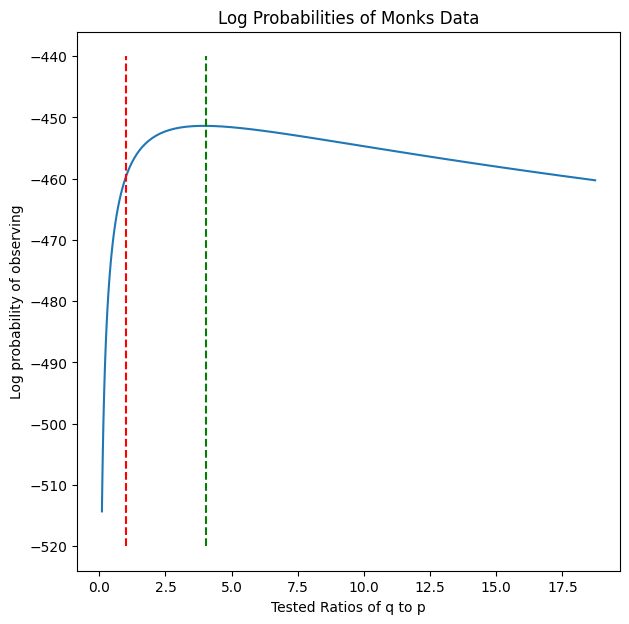

In [ ]:
fig, ax = plt.subplots(figsize=(7,7))


plt.plot(q2p_range, likelihoods_list)
plt.vlines(1,-520,-440, 'r', ls='dashed')
plt.vlines(q2p_best,-520,-440, 'g', ls='dashed')


ax.set_title('Log Probabilities of Monks Data')
ax.set_xlabel('Tested Ratios of q to p')
ax.set_ylabel('Log probability of observing')

# Real Data (Caviar)

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving CAVIAR1.csv to CAVIAR1.csv
Saving CAVIAR2.csv to CAVIAR2.csv
Saving CAVIAR3.csv to CAVIAR3.csv
Saving CAVIAR4.csv to CAVIAR4.csv
Saving CAVIAR5.csv to CAVIAR5.csv
Saving CAVIAR6.csv to CAVIAR6.csv
Saving CAVIAR7.csv to CAVIAR7.csv
Saving CAVIAR8.csv to CAVIAR8.csv
Saving CAVIAR9.csv to CAVIAR9.csv
Saving CAVIAR10.csv to CAVIAR10.csv
Saving CAVIAR11.csv to CAVIAR11.csv


In [ ]:
#Import Caviar Criminal Networks Data
#Note: in this data, edges are both added AND deleted. This may lead to our model not being the best representation

# caviar_data = np.genfromtxt(io.BytesIO(uploaded['CAVIAR_FULL.csv']), delimiter=',') #maybe retry with caviar1-11?

# caviar_matrix = np.array(caviar_data)

# G = nx.from_numpy_array(caviar_matrix)



c1 = np.genfromtxt(io.BytesIO(uploaded['CAVIAR1.csv']), delimiter=',')
c2 = np.genfromtxt(io.BytesIO(uploaded['CAVIAR2.csv']), delimiter=',')
c3 = np.genfromtxt(io.BytesIO(uploaded['CAVIAR3.csv']), delimiter=',')
c4 = np.genfromtxt(io.BytesIO(uploaded['CAVIAR4.csv']), delimiter=',')
c5 = np.genfromtxt(io.BytesIO(uploaded['CAVIAR5.csv']), delimiter=',')
c6 = np.genfromtxt(io.BytesIO(uploaded['CAVIAR6.csv']), delimiter=',')
c7 = np.genfromtxt(io.BytesIO(uploaded['CAVIAR7.csv']), delimiter=',')
c8 = np.genfromtxt(io.BytesIO(uploaded['CAVIAR8.csv']), delimiter=',')
c9 = np.genfromtxt(io.BytesIO(uploaded['CAVIAR9.csv']), delimiter=',')
c10 = np.genfromtxt(io.BytesIO(uploaded['CAVIAR10.csv']), delimiter=',')
c11 = np.genfromtxt(io.BytesIO(uploaded['CAVIAR11.csv']), delimiter=',')


A_list = [c1, c2, c3, c4, c5, c6, c7, c8, c9, c10, c11]


edges = []

for At in A_list:
  At[At==9.0] = 0
  At[At==6.0] = 0
  Gt = nx.from_numpy_array(At[1:,1:]) # Do 1:,1: any time adj matrices have labels to exclude first row & column
  for e in Gt.edges:
    edges.append(e)


edge_set = set(edges)
edge_list_nd = list(edge_set) # Remove duplicate edges in edgelist


G = nx.from_edgelist(edge_list_nd)



e = nx.edges(G)
edge_count = len(e)
print(edge_count)

nodes_list = nx.nodes(G)
n = len(nodes_list)
print(n)



242
42


In [ ]:
#Temporal Network Stats


G_list = []

G_list = [nx.from_numpy_array(At[1:,1:]) for At in A_list]



temp_net_stats(G_list)


There are 11 timestamps
This graph is not directed
This graph is weighted
The graph does not have self-loops. 

The max nodes are 42
The min nodes are 15
The avg nodes are 32.72727272727273 

The max edges are 55
The min edges are 18
The avg edges are 43.18181818181818 

37 edges were added 

The max degree is 3.4814814814814814
The min degree is 2.25
The avg degree is 2.6469820196196228 

The max clustering coeff is 0.5298514847534456
The min clustering coeff is 0.11128299804770393
The avg clustering coeff is 0.2665621092205115 

The max diameter is inf
The min diameter is 3
The avg diameter is inf 

Connected timestamps: 54.55% 6
Disconnected timestamps: 45.45% 5 



In [ ]:
G0 = np.zeros((n,n))

Gt, edges = TCER(G0,q=0.5, p=0.1, t=100)

In [ ]:
G = nx.from_numpy_array(Gt)


In [ ]:
fig, ax = plt.subplots(figsize=(9,9))
plt.xticks([])
plt.yticks([])
pos=nx.spring_layout(G, seed=42)
pos[11] = [-0.5,0]
print(pos[11])
nx.draw_networkx(G, pos=pos, with_labels=True, #Edges not very visible, some edges of giant component visible
                  node_color='c')

def plot_degree_dist(G):
    degrees = [G.degree(n) for n in G.nodes()]
    plt.hist(degrees)
    plt.show()

plot_degree_dist(G)
#Run through all graphs again, remove title, reinsert to overleaf, slightly increase size


#Difference in p and q will vary depending on the qualities of the network such as its constraints on edge formation
#In criminal networks, mutual contacts do not want to develop relationships for fear of undercover police, etc.
#Formed like this IOT be resistant to capture of a single node

NameError: name 'plt' is not defined

In [ ]:

G0 = np.zeros_like(Gt)
prob_list = edge_likelihoods(G0, edges, q =.15, p = .02)
pq_likelihood = sum([np.log(p) for p in prob_list])
print(pq_likelihood)



-636.9993790986717


In [ ]:
q2p_range = np.logspace(-1,2,100)
q2p_range = np.sort(np.append(q2p_range,1))
q2p_range = q2p_range[q2p_range<20]
likelihoods_list = []
for q2p in q2p_range:
  G0 = np.zeros_like(Gt)
  pcur = 1e-2
  qcur = pcur*q2p
  prob_list = edge_likelihoods(G0, edges, q = qcur, p = pcur)
  pq_likelihood = sum([np.log(p) for p in prob_list])
  likelihoods_list.append(pq_likelihood)


In [ ]:
ER_index = (q2p_range==1).argmax()
print(ER_index)

likelihood_arr = np.array(likelihoods_list)

q2p_best = q2p_range[likelihood_arr.argmax()]
print("argmax is" , q2p_best) #maximum likelihood ratio of q to p
# what were original params: q=0.5, p=0.1 => q/p = 5

ml = max(likelihoods_list)
# the values that lead to a likelihood at most 10% off ml
ml_threshold = ml + np.log(.80)

print("max is" , ml) #Log of probability of observing edges at best choice of q/p (ratio is 3.76)

ER_likelihood = likelihoods_list[ER_index]
print("ER likelihood is" , ER_likelihood) #this is the log of the probability of observed edges if ER(p=q)


print("Difference between log probabilities is" , max(likelihood_arr)- likelihood_arr[ER_index]) #still in log form

log_diff = ml - ER_likelihood

likelihood_ratio = np.exp(log_diff)
print("ratio is" , likelihood_ratio) #This is the ratio of the probabilities of observing edges for best q/p & q=p


print(q2p_range[likelihood_arr>ml_threshold])

33
argmax is 7.56463327554629
max is -636.9958162440719
ER likelihood is -669.8251008344631
Difference between log probabilities is 32.82928459039124
ratio is 180957731154912.94
[6.57933225 7.05480231 7.56463328 8.11130831 8.69749003]


Text(0, 0.5, 'Log probability of observing')

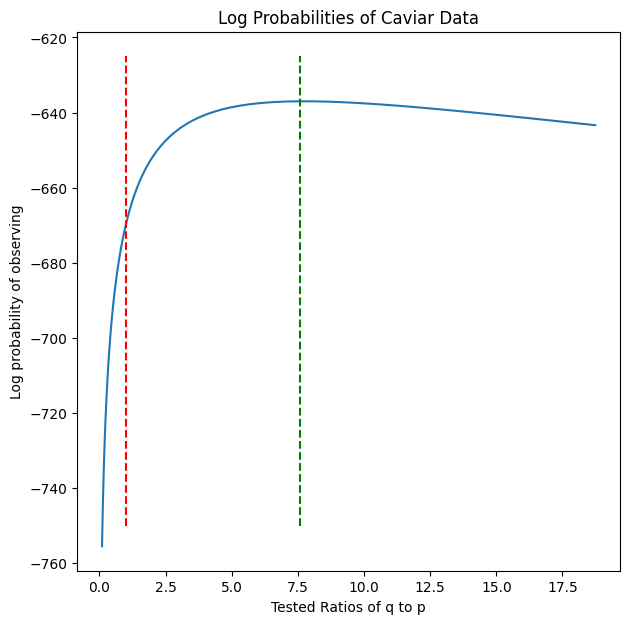

In [ ]:
fig, ax = plt.subplots(figsize=(7,7))



plt.plot(q2p_range, likelihoods_list)
plt.vlines(1,-750,-625, 'r', ls='dashed')
plt.vlines(q2p_best,-750,-625, 'g', ls='dashed')


ax.set_title('Log Probabilities of Caviar Data')
ax.set_xlabel('Tested Ratios of q to p')
ax.set_ylabel('Log probability of observing')

# Real Data (Gronigen University)

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving t1.dat to t1.dat
Saving t2.dat to t2.dat
Saving t3.dat to t3.dat
Saving t4.dat to t4.dat
Saving t5.dat to t5.dat


In [ ]:
t1 = np.loadtxt("t1.dat")
t2 = np.loadtxt("t2.dat")
t3 = np.loadtxt("t3.dat")
t4 = np.loadtxt("t4.dat")
t5 = np.loadtxt("t5.dat")

A_list = [t1, t2, t3, t4, t5]


edges = []

for At in A_list:
  At[At==9.0] = 0
  At[At==6.0] = 0
  Gt = nx.from_numpy_array(At) # verify that this works
  for e in Gt.edges:
    edges.append(e)


edge_set = set(edges)
edge_list_nd = list(edge_set) # Remove duplicate edges in edgelist


G = nx.from_edgelist(edge_list_nd)

adj_test = nx.adjacency_matrix(G) # Now this is a square matrix (38 , 38), how do we get this to work w the rest of code?
# print(adj_test)
# print(np.shape(adj_test))



nodes_list = nx.nodes(G)
n = len(nodes_list)
print(n)


e = nx.edges(G)
number_edges = len(e)
print(number_edges)



38
487


In [ ]:
#Temporal Network Statistics


G_list = []

G_list = [nx.from_numpy_array(At) for At in A_list]


temp_net_stats(G_list) #Help here with connected list & g list



print(len(connected_list))

connected_list not same len as G_list
connected_list not same len as G_list
connected_list not same len as G_list
connected_list not same len as G_list
There are 5 timestamps
This graph is not directed
This graph is weighted
The graph does not have self-loops. 

The max nodes are 38
The min nodes are 38
The avg nodes are 38.0 

The max edges are 346
The min edges are 19
The avg edges are 251.8 

327 edges were added 

The max degree is 18.210526315789473
The min degree is 1.0
The avg degree is 13.25263157894737 

The max clustering coeff is 0.7353072847010261
The min clustering coeff is 0.24122807017543857
The avg clustering coeff is 0.6218001078479809 

The max diameter is inf
The min diameter is 2
The avg diameter is inf 

Connected timestamps: 20.00% 1
Disconnected timestamps: 80.00% 4 

5


In [ ]:
G0 = np.zeros((n,n))

Gt, edges = TCER(G0,q=0.5, p=0.1, t=100)

In [ ]:
G = nx.from_numpy_array(Gt)


Text(0.5, 1.0, 'Groningen Students Network')

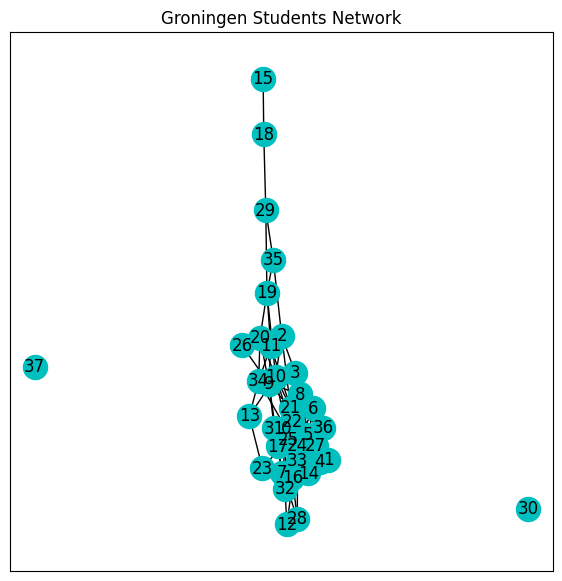

In [ ]:
fig, ax = plt.subplots(figsize=(7,7))
plt.xticks([])
plt.yticks([])
nx.draw_networkx(G, pos=nx.spring_layout(G, seed=4), with_labels=True,
                  node_color='c')

ax.set_title("Groningen Students Network")

In [ ]:
print(np.shape(Gt)) # Why is Gt shape 38, ?

G0 = np.zeros_like(Gt)

print(G0)

prob_list = edge_likelihoods(G0, edges, q =.15, p = .02) #don't understand this error tbh
pq_likelihood = sum([np.log(p) for p in prob_list])
print(pq_likelihood)



(38, 38)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
-628.1770723685777


In [ ]:
q2p_range = np.logspace(-1,2,100)
q2p_range = np.sort(np.append(q2p_range,1))
q2p_range = q2p_range[q2p_range<20]
likelihoods_list = []
for q2p in q2p_range:
  G0 = np.zeros_like(Gt)
  pcur = 1e-2
  qcur = pcur*q2p
  prob_list = edge_likelihoods(G0, edges, q = qcur, p = pcur)
  pq_likelihood = sum([np.log(p) for p in prob_list])
  likelihoods_list.append(pq_likelihood)


In [ ]:
ER_index = (q2p_range==1).argmax()
print(ER_index)

likelihood_arr = np.array(likelihoods_list)

q2p_best = q2p_range[likelihood_arr.argmax()]
print("argmax is" , q2p_best) #maximum likelihood ratio of q to p (i.e. the effect of triadic closure)
# what were original params: q=0.5, p=0.1 => q/p = 5

ml = max(likelihoods_list)
# the values that lead to a likelihood at most 10% off ml
ml_threshold = ml + np.log(.80)

print("max is" , ml) #Log of probability of observing edges at best choice of q/p (ratio is 3.76)

ER_likelihood = likelihoods_list[ER_index]
print("ER likelihood is" , ER_likelihood) #this is the log of the probability of observed edges if ER(p=q)


print("Difference between log probabilities is" , max(likelihood_arr)- likelihood_arr[ER_index]) #still in log form

log_diff = ml - ER_likelihood

likelihood_ratio = np.exp(log_diff)
print("ratio is" , likelihood_ratio) #This is the ratio of the probabilities of observing edges for best q/p & q=p


print(q2p_range[likelihood_arr>ml_threshold])

33
argmax is 4.977023564332112
max is -626.6911862798212
ER likelihood is -648.1365255056438
Difference between log probabilities is 21.445339225822636
ratio is 2058697268.6073802
[4.32876128 4.64158883 4.97702356 5.33669923 5.72236766]


Text(0, 0.5, 'Log probability of observing')

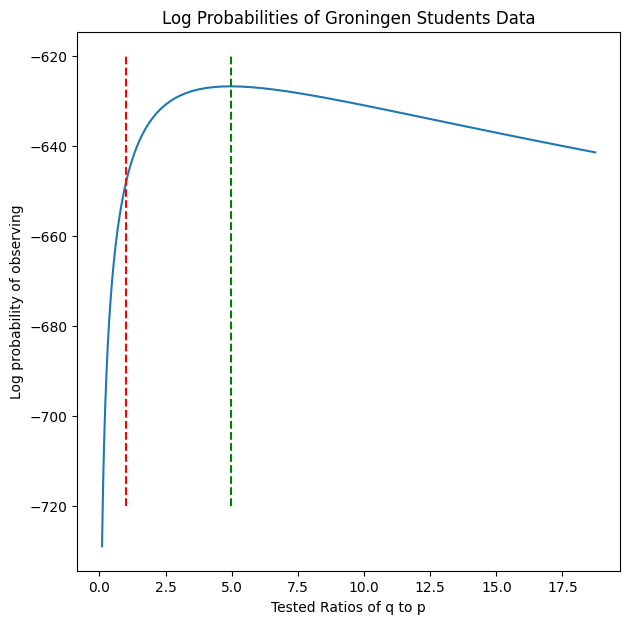

In [ ]:
fig, ax = plt.subplots(figsize=(7,7))

plt.plot(q2p_range, likelihoods_list)
plt.vlines(1,-720,-620, 'r', ls='dashed')
plt.vlines(q2p_best,-720,-620, 'g', ls='dashed')


ax.set_title('Log Probabilities of Groningen Students Data')
ax.set_xlabel('Tested Ratios of q to p')
ax.set_ylabel('Log probability of observing')

# Real Data (Utrecht Secondary School)

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving classroom_net1.dat to classroom_net1.dat
Saving classroom_net2.dat to classroom_net2.dat
Saving classroom_net3.dat to classroom_net3.dat
Saving classroom_net4.dat to classroom_net4.dat


In [ ]:
class_1 = np.loadtxt("classroom_net1.dat")
class_2 = np.loadtxt("classroom_net2.dat")
class_3 = np.loadtxt("classroom_net3.dat")
class_4 = np.loadtxt("classroom_net4.dat")



A_list = [class_1, class_2, class_3, class_4]


edges = []

for At in A_list:
  Gt = nx.from_numpy_array(At) # verify that this works
  for e in Gt.edges:
    edges.append(e)


edge_set = set(edges)
edge_list_nd = list(edge_set) # Remove duplicate edges in edgelist


G = nx.from_edgelist(edge_list_nd)


In [ ]:
G_list = []



G_list = [nx.from_numpy_array(At) for At in A_list]


temp_net_stats(G_list)

There are 4 timestamps
This graph is not directed
This graph is weighted
The graph does not have self-loops. 

The max nodes are 26
The min nodes are 26
The avg nodes are 26.0 

The max edges are 106
The min edges are 63
The avg edges are 87.25 

43 edges were added 

The max degree is 8.153846153846153
The min degree is 4.846153846153846
The avg degree is 6.711538461538461 

The max clustering coeff is 0.5714264368110522
The min clustering coeff is 0.49773581119734955
The avg clustering coeff is 0.5373613565921258 

The max diameter is 7
The min diameter is 4
The avg diameter is 5.5 

Connected timestamps: 100.00% 4
Disconnected timestamps: 0.00% 0 



In [ ]:
G0 = np.zeros((n,n))

Gt, edges = TCER(G0,q=0.5, p=0.1, t=100)

In [ ]:
G = nx.from_numpy_array(Gt)


Text(0.5, 1.0, 'Utrecht School Network')

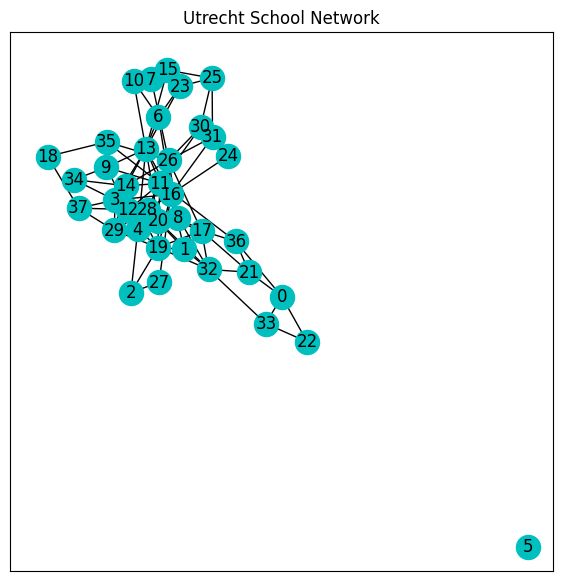

In [ ]:
fig, ax = plt.subplots(figsize=(7,7))
plt.xticks([])
plt.yticks([])
nx.draw_networkx(G, pos=nx.spring_layout(G, seed=4), with_labels=True,
                  node_color='c')

ax.set_title("Utrecht School Network")

In [ ]:
print(np.shape(Gt)) # Why is Gt shape 38, ?

G0 = np.zeros_like(Gt)

print(G0)

prob_list = edge_likelihoods(G0, edges, q =.15, p = .02) #don't understand this error tbh
pq_likelihood = sum([np.log(p) for p in prob_list])
print(pq_likelihood)



(38, 38)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
-614.9588855762009


In [ ]:
q2p_range = np.logspace(-1,2,100)
q2p_range = np.sort(np.append(q2p_range,1))
q2p_range = q2p_range[q2p_range<20]
likelihoods_list = []
for q2p in q2p_range:
  G0 = np.zeros_like(Gt)
  pcur = 1e-2
  qcur = pcur*q2p
  prob_list = edge_likelihoods(G0, edges, q = qcur, p = pcur)
  pq_likelihood = sum([np.log(p) for p in prob_list])
  likelihoods_list.append(pq_likelihood)


In [ ]:
ER_index = (q2p_range==1).argmax()
print(ER_index)

likelihood_arr = np.array(likelihoods_list)

q2p_best = q2p_range[likelihood_arr.argmax()]
print("argmax is" , q2p_best) #maximum likelihood ratio of q to p (i.e. the effect of triadic closure)
# what were original params: q=0.5, p=0.1 => q/p = 5

ml = max(likelihoods_list)
# the values that lead to a likelihood at most 10% off ml
ml_threshold = ml + np.log(.80)

print("max is" , ml) #Log of probability of observing edges at best choice of q/p (ratio is 3.76)

ER_likelihood = likelihoods_list[ER_index]
print("ER likelihood is" , ER_likelihood) #this is the log of the probability of observed edges if ER(p=q)


print("Difference between log probabilities is" , max(likelihood_arr)- likelihood_arr[ER_index]) #still in log form

log_diff = ml - ER_likelihood

likelihood_ratio = np.exp(log_diff)
print("ratio is" , likelihood_ratio) #This is the ratio of the probabilities of observing edges for best q/p & q=p


print(q2p_range[likelihood_arr>ml_threshold])

33
argmax is 7.56463327554629
max is -614.9541310587996
ER likelihood is -648.1365255056438
Difference between log probabilities is 33.18239444684423
ratio is 257591070884937.16
[6.57933225 7.05480231 7.56463328 8.11130831 8.69749003]


Text(0, 0.5, 'Log probability of observing')

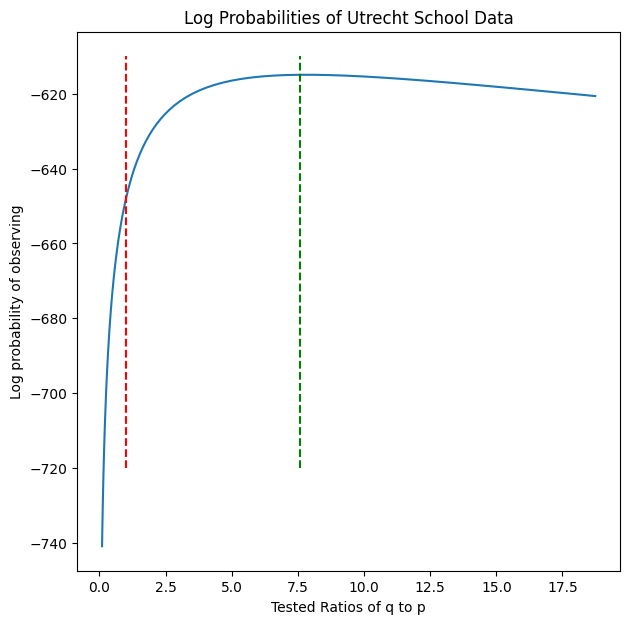

In [ ]:
fig, ax = plt.subplots(figsize=(7,7))

plt.plot(q2p_range, likelihoods_list)
plt.vlines(1,-720,-610, 'r', ls='dashed')
plt.vlines(q2p_best,-720,-610, 'g', ls='dashed')


ax.set_title('Log Probabilities of Utrecht School Data')
ax.set_xlabel('Tested Ratios of q to p')
ax.set_ylabel('Log probability of observing')